In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)


In [6]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('BostonHousingData.csv')
house_df.take(1)

[Row(CRIM='0.00632', ZN='18', INDUS='2.31', CHAS='0', NOX=0.538, RM=6.575, AGE='65.2', DIS=4.09, RAD=1, TAX=296, PTRATIO=15.3, B=396.9, LSTAT='4.98', MEDV=24.0)]

In [7]:
house_df.cache()
house_df.printSchema()

root
 |-- CRIM: string (nullable = true)
 |-- ZN: string (nullable = true)
 |-- INDUS: string (nullable = true)
 |-- CHAS: string (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: string (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: string (nullable = true)
 |-- MEDV: double (nullable = true)



In [8]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6118739711934156,8.7201918501516,0.00632,NA
ZN,506,11.2119341563786,23.388876146265478,0,NA
INDUS,506,11.083991769547332,6.835896498641436,0.46,NA
CHAS,506,0.06995884773662552,0.255340480906568,0,NA
NOX,506,0.5546950592885372,0.11587767566755584,0.385,0.871
RM,506,6.284634387351787,0.7026171434153232,3.561,8.78
AGE,506,68.51851851851852,27.999513005092354,10,NA
DIS,506,3.795042687747034,2.10571012662761,1.1296,12.1265
RAD,506,9.549407114624506,8.707259384239366,1,24


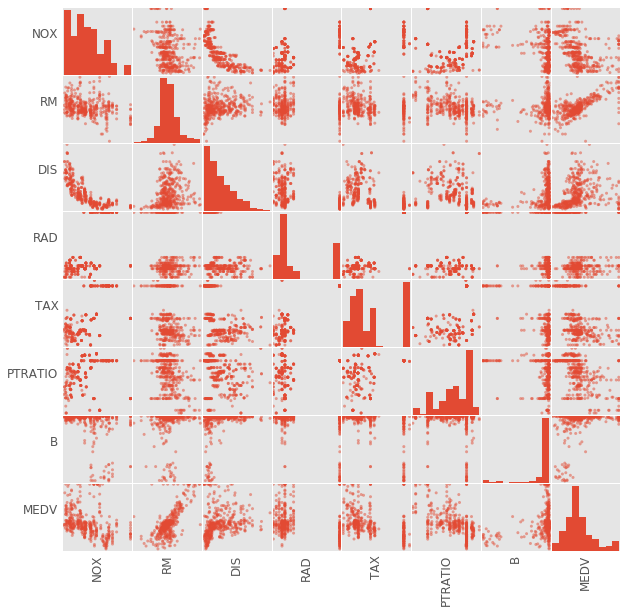

In [14]:
import pandas as pd
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [16]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MEDV',i))

Correlation to MV for  NOX -0.4273207723732821
Correlation to MV for  RM 0.6953599470715401
Correlation to MV for  DIS 0.249928734085904
Correlation to MV for  RAD -0.38162623063977735
Correlation to MV for  TAX -0.46853593356776674
Correlation to MV for  PTRATIO -0.5077866855375622
Correlation to MV for  B 0.3334608196570661
Correlation to MV for  MEDV 1.0


In [21]:
house_df.columns

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'MEDV']

In [22]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['NOX','RM','DIS','RAD','TAX','PTRATIO','B','MEDV'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MEDV'])
vhouse_df.show(3)

+--------------------+----+
|            features|MEDV|
+--------------------+----+
|[0.538,6.575,4.09...|24.0|
|[0.469,6.421,4.96...|21.6|
|[0.469,7.185,4.96...|34.7|
+--------------------+----+
only showing top 3 rows



In [23]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [25]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MEDV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9686167724946497]
Intercept: 0.7200344167069979


In [26]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.299356
r2: 0.999015


RMSE es la diferencia entre los valores que predice el modelo y el valor real
R al cuadrado indica que en el modelo aprox. el 99% de la variabilidad en MDEV es explicada con el modelo. Es una buena medida

In [27]:
train_df.describe().show()

+-------+------------------+
|summary|              MEDV|
+-------+------------------+
|  count|               365|
|   mean|22.943287671232856|
| stddev| 9.551813022597662|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [31]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MEDV","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MEDV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
|22.029603411589292|22.0|[0.389,6.453,7.30...|
|20.964124961845176|20.9|[0.392,5.876,9.22...|
|21.932741734339825|21.9|[0.392,6.108,9.22...|
|  19.5111998031032|19.4|[0.398,5.787,6.61...|
|24.741730374574313|24.8|[0.4,6.871,7.8278...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.998983


In [32]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.258836


In [33]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.4332928862129384, 0.11026939974144151, 0.08087807604576697, 0.04936602106386316, 0.030608553600505004, 0.02842592645415884, 0.027995251717614553, 0.02782070333239461, 0.02781443615403878, 0.027814211130332948]
+--------------------+
|           residuals|
+--------------------+
|-0.08923154384945775|
|  0.6608275935284098|
|0.017471429668734828|
|-0.01391179783661...|
| 0.29050550896528193|
| 0.25598395870939683|
|  0.8491269585605181|
|  0.3752402232297314|
|  0.3124737682190286|
|  0.3909318369823964|
|  0.3658252549781267|
|-0.02018844333768...|
|0.058269625425687366|
|-0.17396625811390365|
|-0.12689141685587657|
|-0.13630638510748128|
| 0.15555763069227524|
|  0.2716755724620725|
|-0.14885967610962325|
|-0.07353993009678206|
+--------------------+
only showing top 20 rows



In [35]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","MEDV","features").show()

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
|22.029603411589292|22.0|[0.389,6.453,7.30...|
|20.964124961845176|20.9|[0.392,5.876,9.22...|
|21.932741734339825|21.9|[0.392,6.108,9.22...|
|  19.5111998031032|19.4|[0.398,5.787,6.61...|
|24.741730374574313|24.8|[0.4,6.871,7.8278...|
| 28.80992081905184|29.0|[0.4,7.041,7.8278...|
|28.906782496301307|29.1|[0.401,6.604,6.21...|
|30.069122623294884|30.3|[0.404,7.107,7.30...|
| 32.97497294077883|33.3|[0.404,7.287,7.30...|
| 23.19194353858287|23.2|[0.405,6.209,7.31...|
|22.029603411589292|22.0|[0.409,5.878,6.49...|
|20.964124961845176|20.9|[0.409,5.885,6.49...|
|24.644868697324846|24.7|[0.41,6.383,9.187...|
|29.875399268795956|30.1|[0.41,6.728,12.12...|
|24.063698633828057|24.1|[0.411,6.579,10.7...|
|28.325612432804515|28.5|[0.411,6.861,5.11...|
|36.849440030757435|37.3|[0.411,7.148,5.11...|
|24.063698633828057|24.1|[0.415,6.162,6.27...|
|47.697947882